In [83]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import STLForecast
from scipy.stats import pearsonr
import numpy as np
import seaborn as sns
from scipy.signal import find_peaks

In [23]:
# Load the data
security = pd.read_csv('data/all_securities.csv', header = 0)
sentiment = pd.read_csv('data/daily_data.csv', header = 0)
# Transform 'Date' column to datetime and set as index
security['Date'] = pd.to_datetime(security['Date'])
security.set_index('Date', inplace=True)
security.index = security.index.date

sentiment['Date'] = pd.to_datetime(sentiment['stock_date'])
sentiment.set_index('Date', inplace=True)

# Join the DataFrames on their index (date)
merged_data = sentiment.join(security, how='inner')

In [40]:
merged_data

,stock_date,pos.meanSS,pos.sumSS,pos.numTweets,neg.meanSS,neg.sumSS,neg.numTweets,neu.meanSS,neu.sumSS,neu.numTweets,...,XLK_Open,XLK_High,XLK_Low,XLK_Close,XLK_Volume,SNP_Open,SNP_High,SNP_Low,SNP_Close,SNP_Volume
2021-12-31,2021-12-31,0.776122,6.208978,8.0,0.824446,3.297786,4.0,0.642830,3.856979,6.0,...,174.55,174.97,173.79,173.87,5121541,4775.21,4786.83,4765.75,4766.18,1340241237
2022-01-03,2022-01-03,0.774334,7.743335,10.0,0.799727,63.978195,80.0,0.668923,15.385224,23.0,...,174.10,175.68,173.34,175.52,10151434,4778.14,4796.64,4758.17,4796.56,2209533436
2022-01-04,2022-01-04,0.802162,36.097300,45.0,0.832114,49.094727,59.0,0.665973,23.309066,35.0,...,175.82,176.00,172.35,173.66,8323998,4804.51,4818.62,4774.27,4793.54,2813805151
2022-01-05,2022-01-05,0.777522,33.433461,43.0,0.788174,47.290414,60.0,0.696415,16.713949,24.0,...,172.65,172.78,168.26,168.32,11814245,4787.99,4797.70,4699.44,4700.58,2803729359
2022-01-06,2022-01-06,0.771683,10.803558,14.0,0.841266,23.555453,28.0,0.692383,17.309568,25.0,...,166.98,169.20,166.47,167.47,11883563,4693.39,4725.01,4671.26,4696.05,2379822969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,2022-09-26,0.842902,12.643529,15.0,0.810767,21.079938,26.0,0.662482,7.949784,12.0,...,123.36,125.43,122.53,122.88,8597045,3682.72,3715.67,3644.76,3655.04,2634968922
2022-09-27,2022-09-27,0.798400,17.564809,22.0,0.831107,37.399823,45.0,0.684704,14.378788,21.0,...,124.51,125.68,121.90,123.04,9357359,3686.44,3717.53,3623.29,3647.29,2548804869
2022-09-28,2022-09-28,0.817760,23.715030,29.0,0.869796,27.833461,32.0,0.715359,17.883985,25.0,...,122.22,124.94,121.28,124.34,9466697,3651.94,3736.74,3640.61,3719.04,2637914627
2022-09-29,2022-09-29,0.815122,22.008304,27.0,0.842963,32.875566,39.0,0.639683,18.550808,29.0,...,122.56,122.84,119.67,121.10,15548343,3687.01,3687.01,3610.40,3640.47,2601213630


### Sentiment - Lag analysis
Purpose: Determine whether sentiment changes lead or lag changes in stock prices and by how much.
Result:
Limitation: In the social media era, infomration travels and expand in a much faster speed and within minitues, investors could react on the new infomration or formed information via their investing decision and thereafter impact the stock price. Thus, in-corporate a lag effect on daily data is not sufficient to the real world application, which opens up an opportunity to expand the futre scope of this study to work with hourly or even more frequent stock and social media data.

In [81]:


# Define lag periods
lag_periods = [0, 1, 2, 3, 4, 5] 
sentiment_score_types = ['pos.meanSS', 'pos.sumSS', 'pos.numTweets', 'neg.meanSS',
       'neg.sumSS', 'neg.numTweets', 'neu.meanSS', 'neu.sumSS',
       'neu.numTweets', 'percent_pos', 'percent_neg', 'percent_neu']
# Calculate sentiment-price lag correlation for each lag period

correlation_results = []
p_value_results = []

# Calculate sentiment-price lag correlation for each sentiment score type and lag period
for sentiment_score in sentiment_score_types:
    for lag in lag_periods:
        # Calculate correlation coefficient and p-value
        sentiment_lagged = merged_data[sentiment_score].shift(-lag).fillna(0)
        correlation, p_value = pearsonr(sentiment_lagged, merged_data['DELL_Close'].fillna(0))
        correlation_results.append(correlation)
        p_value_results.append(p_value)

# Create DataFrame to store results
results_df = pd.DataFrame({
    'Sentiment Score Type': [score for score in sentiment_score_types for _ in range(len(lag_periods))],
    'Lag Period': lag_periods * len(sentiment_score_types),
    'Correlation Coefficient': correlation_results,
    'P-value': p_value_results
})

# Filter rows with p-value less than 0.1
filtered_results_df = results_df[results_df['P-value'] < 0.1]

# Display filtered results
print(filtered_results_df)

   Sentiment Score Type  Lag Period  Correlation Coefficient   P-value
0            pos.meanSS           0                -0.184595  0.010996
2            pos.meanSS           2                 0.147298  0.043112
3            pos.meanSS           3                 0.206771  0.004308
4            pos.meanSS           4                 0.259602  0.000309
5            pos.meanSS           5                 0.302461  0.000023
18           neg.meanSS           0                -0.160243  0.027622
20           neg.meanSS           2                 0.167333  0.021367
21           neg.meanSS           3                 0.219110  0.002452
22           neg.meanSS           4                 0.268165  0.000191
23           neg.meanSS           5                 0.306004  0.000019
29            neg.sumSS           5                 0.121085  0.096972
35        neg.numTweets           5                 0.121826  0.094930
36           neu.meanSS           0                -0.121634  0.095455
38    

In [73]:
# Calculate lagged returns
merged_data['DELL_Returns'] = merged_data['DELL_Close'].pct_change()

# Define lag periods
lag_periods = [0, 1, 2, 3, 4, 5] 
sentiment_score_types = ['pos.meanSS', 'pos.sumSS', 'pos.numTweets', 'neg.meanSS',
       'neg.sumSS', 'neg.numTweets', 'neu.meanSS', 'neu.sumSS',
       'neu.numTweets', 'percent_pos', 'percent_neg', 'percent_neu']
# Calculate sentiment-price lag correlation for each lag period

correlation_results = []
p_value_results = []

# Calculate sentiment-price lag correlation for each sentiment score type and lag period
for sentiment_score in sentiment_score_types:
    for lag in lag_periods:
        # Calculate correlation coefficient and p-value
        sentiment_lagged = merged_data[sentiment_score].shift(-lag).fillna(0)
        correlation, p_value = pearsonr(sentiment_lagged, merged_data['DELL_Returns'].fillna(0))
        correlation_results.append(correlation)
        p_value_results.append(p_value)

# Create DataFrame to store results
results_df = pd.DataFrame({
    'Sentiment Score Type': [score for score in sentiment_score_types for _ in range(len(lag_periods))],
    'Lag Period': lag_periods * len(sentiment_score_types),
    'Correlation Coefficient': correlation_results,
    'P-value': p_value_results
})

# Filter rows with p-value less than 0.1
filtered_results_df = results_df[results_df['P-value'] < 0.1]

# Display filtered results
print(filtered_results_df)

   Sentiment Score Type  Lag Period  Correlation Coefficient   P-value
25            neg.sumSS           1                 0.130358  0.073796
31        neg.numTweets           1                 0.129456  0.075832
36           neu.meanSS           0                 0.120236  0.099356
54          percent_pos           0                -0.125770  0.084628
66          percent_neu           0                 0.152657  0.035988
69          percent_neu           3                -0.147394  0.042974


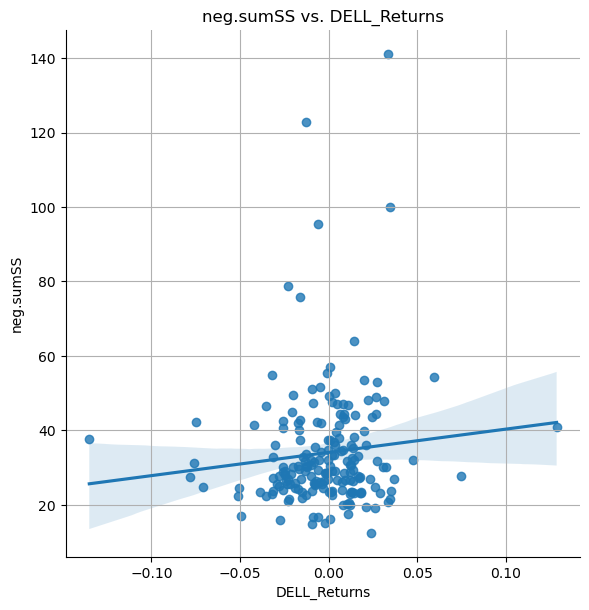

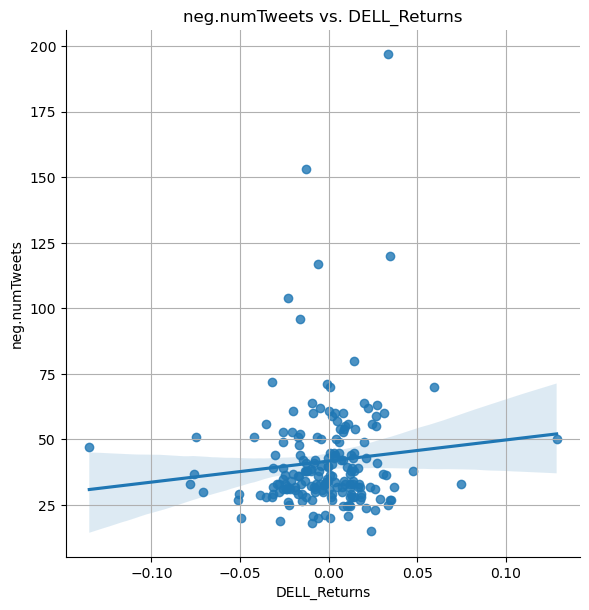

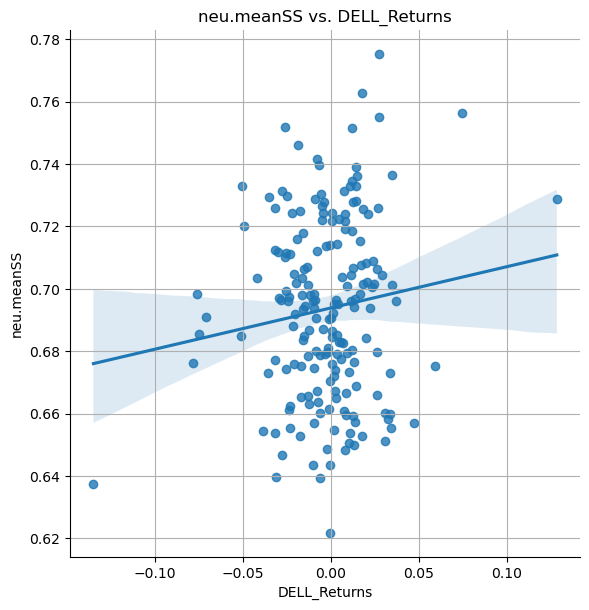

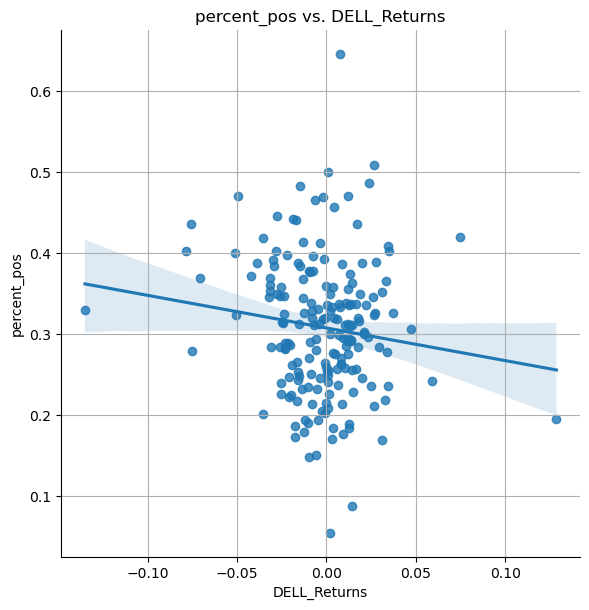

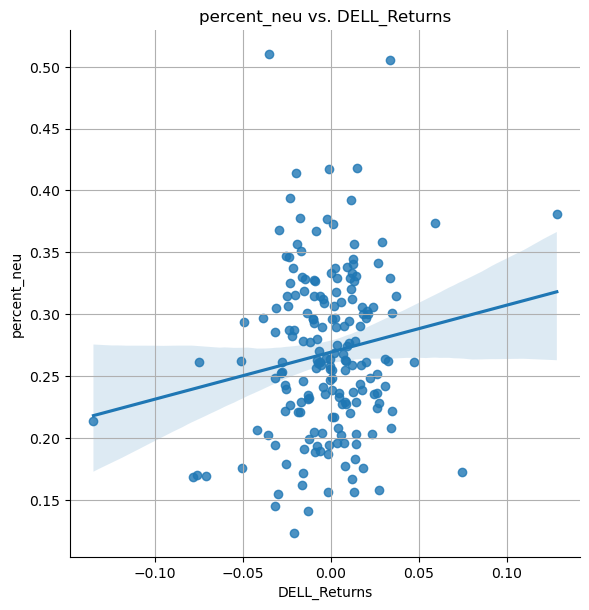

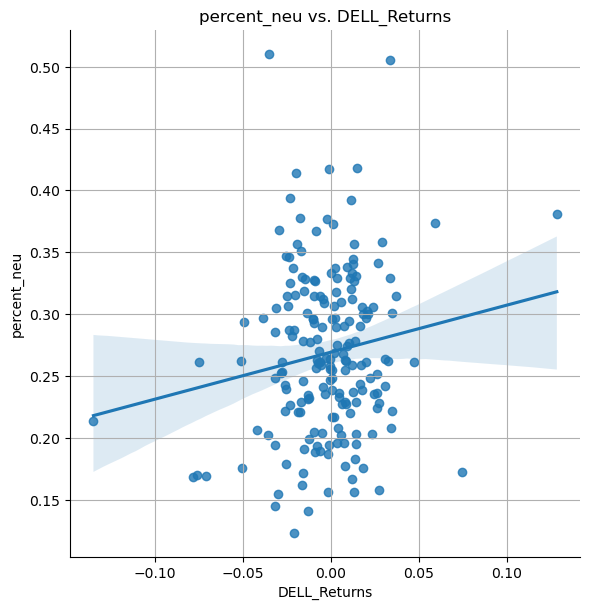

In [78]:

# Define the sentiment score types to plot
sentiment_score_types = ['neg.sumSS', 'neg.numTweets', 'neu.meanSS', 'percent_pos', 'percent_neu', 'percent_neu']


for sentiment_score in sentiment_score_types:
    sns.lmplot(x='DELL_Returns', y=sentiment_score, data=merged_data, height=6)
    plt.title(f'{sentiment_score} vs. DELL_Returns')
    plt.grid(True)
    plt.show()

In [103]:

threshold = 0.7
correlation_coefficients = {}
results = {}

# Iterate over each sentiment score type
for sentiment_score_type in sentiment_score_types:
    # Identify significant changes in sentiment score type data
    sentiment_changes = merged_data[sentiment_score_type].pct_change().abs() > threshold

    # Extract corresponding 'DELL_Returns' values for each significant change in sentiment score type data
    returns_at_changes = merged_data.loc[sentiment_changes, 'DELL_Returns']
    sentiment_scores_at_changes = merged_data.loc[sentiment_changes, sentiment_score_type]

    # Check if both arrays have at least two elements
    if len(returns_at_changes) >= 2 and len(sentiment_scores_at_changes) >= 2:
        # Calculate correlation coefficient and p-value
        correlation_coefficient, p_value = pearsonr(returns_at_changes, sentiment_scores_at_changes)

        # Store results
        results[sentiment_score_type] = {'Correlation Coefficient': correlation_coefficient, 'P-value': p_value}

# Create DataFrame to store results
results_df = pd.DataFrame(results).T

# Display results
print(results_df)




               Correlation Coefficient   P-value
pos.sumSS                     0.210532  0.264120
pos.numTweets                 0.174783  0.383228
neg.sumSS                     0.347568  0.133211
neg.numTweets                 0.381287  0.088119
neu.sumSS                     0.194797  0.320549
neu.numTweets                 0.207284  0.271729
percent_pos                  -0.094337  0.738065
percent_neg                   0.314688  0.543550
percent_neu                   0.091849  0.776488


In [115]:
sentiment_changes = merged_data['neg.numTweets'].pct_change().abs() > 0.7
sentiment_changes[sentiment_changes==True]
merged_data['neg.numTweets'].pct_change().loc[sentiment_changes]


2022-01-03    19.000000
2022-02-01     1.432432
2022-02-23     1.659091
2022-03-14     0.816667
2022-03-21     1.391304
2022-04-05     0.702703
2022-04-12     1.500000
2022-04-21     0.833333
2022-04-26     0.777778
2022-04-28     1.814286
2022-05-25     0.707317
2022-06-07     1.021739
2022-06-21     2.750000
2022-06-23    -0.777778
2022-07-19     0.964286
2022-07-26     1.021053
2022-08-02     1.148649
2022-08-23     1.011364
2022-08-31     1.240000
2022-09-14     1.500000
2022-09-27     0.730769
Name: neg.numTweets, dtype: float64

In [113]:
returns_at_changes = merged_data.loc[sentiment_changes, 'DELL_Returns']
returns_at_changes

2022-01-03    0.014421
2022-02-01    0.030980
2022-02-23   -0.006126
2022-03-14   -0.024418
2022-03-21    0.009454
2022-04-05   -0.014581
2022-04-12    0.003195
2022-04-21   -0.016122
2022-04-26   -0.016078
2022-04-28    0.033727
2022-05-25    0.059198
2022-06-07    0.022182
2022-06-21    0.034461
2022-06-23    0.008846
2022-07-19    0.026573
2022-07-26   -0.009578
2022-08-02   -0.025539
2022-08-23    0.002135
2022-08-31   -0.035273
2022-09-14   -0.004439
2022-09-27    0.000576
Name: DELL_Returns, dtype: float64